In [1]:
import pickle
import CO2_Dataset_Preparation
import CO2_functions
import CO2_Processing
from CO2_Dataset_Preparation import *
from CO2_functions import * 
from CO2_Processing import *

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.dates as mdates
import matplotlib
from matplotlib import gridspec
import pickle

import importlib
importlib.reload(CO2_functions)
importlib.reload(CO2_Processing)
importlib.reload(CO2_Dataset_Preparation)

from CO2_Dataset_Preparation import *
from CO2_functions import *
from CO2_Processing import *

%load_ext rpy2.ipython

In [ ]:
idx = pd.date_range(start = '2019-08-15 00:00:00',end = '2019-11-27 23:00:00',freq ='S')
alldf = pd.DataFrame({'dt':idx})
alldf.set_index('dt',inplace  =True)

In [ ]:
tower = 'Picarro'
picarro_df = pd.DataFrame()
for i in range(1,7):
    position_number = i
    excess_rolls_sec = [60,600,3600]
    downsample_sec = 1

    data = Processed_Set(tower,position_number,excess_rolls_sec,vent_bool = True,wbb_bool=True)
    data._retrieve_data('../CO2_Data_Processed/')
    data._apply_excess(delete_min_cols=False)
    
    picarro_df = pd.concat([picarro_df,data.data['Picarro'].resample('1S').mean()],axis = 0)

In [ ]:
tower = 'Multi'
multi_df = pd.DataFrame()
wbb_df = pd.DataFrame()
for i in range(1,4):
    position_number = i
    excess_rolls_sec = [60,600,3600]
    downsample_sec = 1

    data = Processed_Set(tower,position_number,excess_rolls_sec,vent_bool = True,wbb_bool=True)
    data._retrieve_data('../CO2_Data_Processed/')
    data._apply_excess(delete_min_cols=False)
    
    multi_df = pd.concat([multi_df,data.data['Multi']],axis = 0)
    wbb_df = pd.concat([wbb_df,data.data['Vent_Mass']],axis = 0)
multi_df.sort_index(axis = 'index',inplace = True)
wbb_df.sort_index(axis = 'index',inplace = True)
wbb_df.drop(['Rotations','Q'],axis = 1,inplace = True)
wbb_cols = ['Vent_Raw_Conc','Vent_Exit_Vel','Vent_Inner_Temp','Vent_Outer_Temp','WBB_CO2','WBB_CH4','Vent_Excess_Conc','Vent_Mass_Flow']
wbb_df.columns = wbb_cols
multi_df.rename(columns = {'Temp':'Multi_Temp','ws' : 'Multi_WS','wd':'Multi_WD'},inplace = True)

In [ ]:
alldf = pd.concat([alldf,picarro_df,multi_df,wbb_df],axis=1).reindex(alldf.index)

In [ ]:
pickle_out = open('../CO2_Data_Processed/all_df_concatenated.pkl','wb')
pickle.dump(alldf,pickle_out)
pickle_out.close()

In [2]:
pickle_in = open('../CO2_Data_Processed/all_df_concatenated.pkl','rb')
alldf = pickle.load(pickle_in)

# ----------------
# General Plot
# ----------------

/uufs/chpc.utah.edu/common/home/u0890904/software/pkg/miniconda3/envs/CO2_Eddy/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


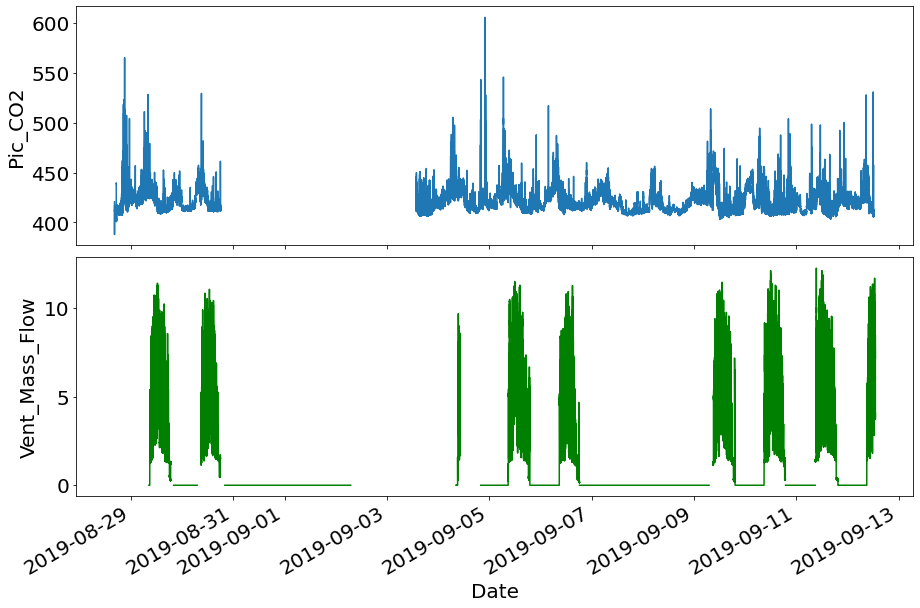

In [3]:
labsize = 20
position_number = 2
ghg = 'Pic_CO2'
baseline_roll = 3600

#To just view one position worth of data, input number to position_number
if position_number!='all':
    plot_df = alldf.loc[alldf['Pic_Loc']==position_number]
else:
    plot_df = alldf

start = 'all'#'2019-09-09'
end = '2019-09-11'
if start != 'all':
    plot_df = plot_df.loc[(plot_df.index>start)&(plot_df.index<end)]

fig = plt.figure(figsize=(15,10))

gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1]) 
gs.update(hspace=0.05)

#Top plot
y_ax0 = 'Pic_CO2'

ax0 = fig.add_subplot(gs[0])
ax0.plot(plot_df.index,plot_df[y_ax0],label='Effluent CO2 (Picarro Sampler)')
ax0.label_outer()
ax0.tick_params(axis='both', which='major', labelsize=labsize)
ax0.set_ylabel(y_ax0,size=labsize)

#Bottom Plot
y_ax1 = 'Vent_Mass_Flow'
ax1 = fig.add_subplot(gs[1],sharex=ax0)
ax1.plot(plot_df.index,plot_df[y_ax1],'g')
ax1.tick_params(axis='both', which='major', labelsize=labsize)
ax1.set_ylabel(y_ax1,size=labsize)
ax1.set_xlabel('Date',size=labsize)


plt.gcf().autofmt_xdate()
fig.tight_layout()

# --------------------
# Baseline Plotting
# --------------------

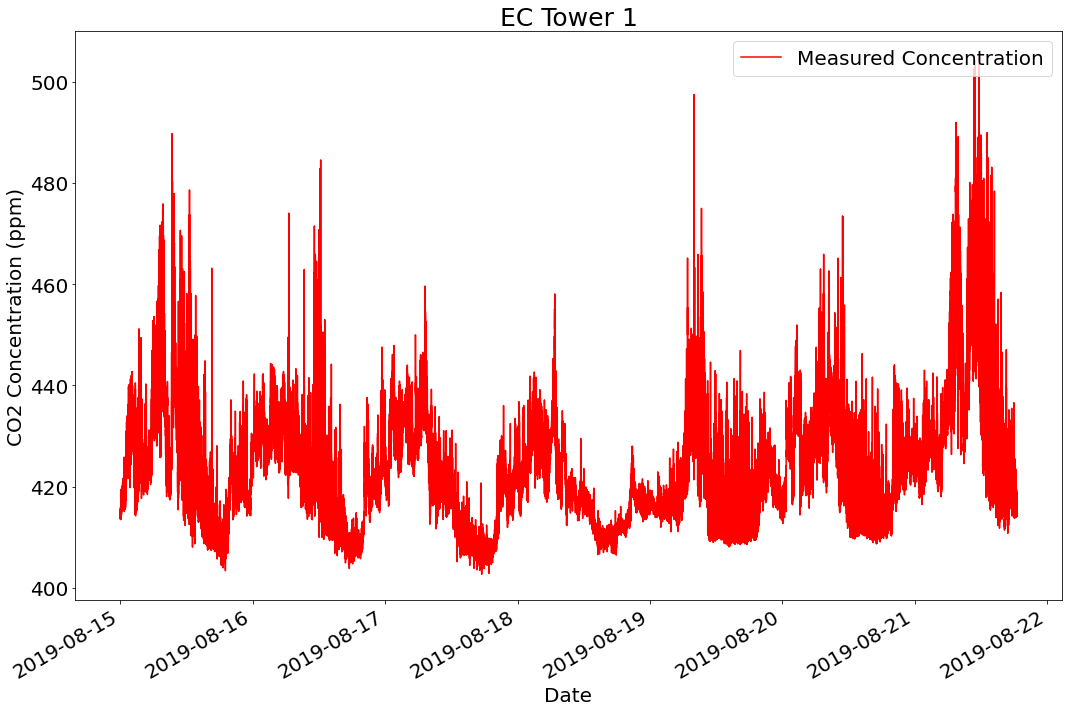

In [29]:
#Plot Measured Concentration over Baseline
labsize = 20

tower = 'Picarro'
position_number = 1
ghg = 'Pic_CO2'
baseline_roll = 3600
y_ax = ghg

plot_df = alldf.loc[alldf['Pic_Loc']==position_number]

start = 'all'#'2019-09-09'
end = '2019-09-11'
if start != 'all':
    plot_df = plot_df.loc[(plot_df.index>start)&(plot_df.index<end)]

fig,ax=plt.subplots(figsize=[15,10])

ax.plot(plot_df.index,plot_df[f'{y_ax}'],color='red',alpha=1,label = 'Measured Concentration')
#ax.plot(plot_df.index,plot_df[f'min_r{baseline_roll}_{ghg}'].rolling(baseline_roll,center = True).mean(),linewidth=2,color='black',label = f'Baseline')

if ghg == 'Pic_CH4':
    ylab = 'CH4 Concentration (ppm)'
elif ghg == 'Pic_CO2':
    ylab = 'CO2 Concentration (ppm)'

ax.set_xlabel('Date',size=labsize)
ax.set_ylabel(ylab,size=labsize)
ax.tick_params(axis='both', which='major', labelsize=labsize)
ax.legend(fontsize = labsize,loc = 1)

ax.set_title(f'EC Tower {position_number}',size = labsize+5)

plt.gcf().autofmt_xdate()
fig.tight_layout()
plt.show()

fig.savefig('../CO2_Data_Processed/Plots_Figs/CO2_baseline_comparison.png')

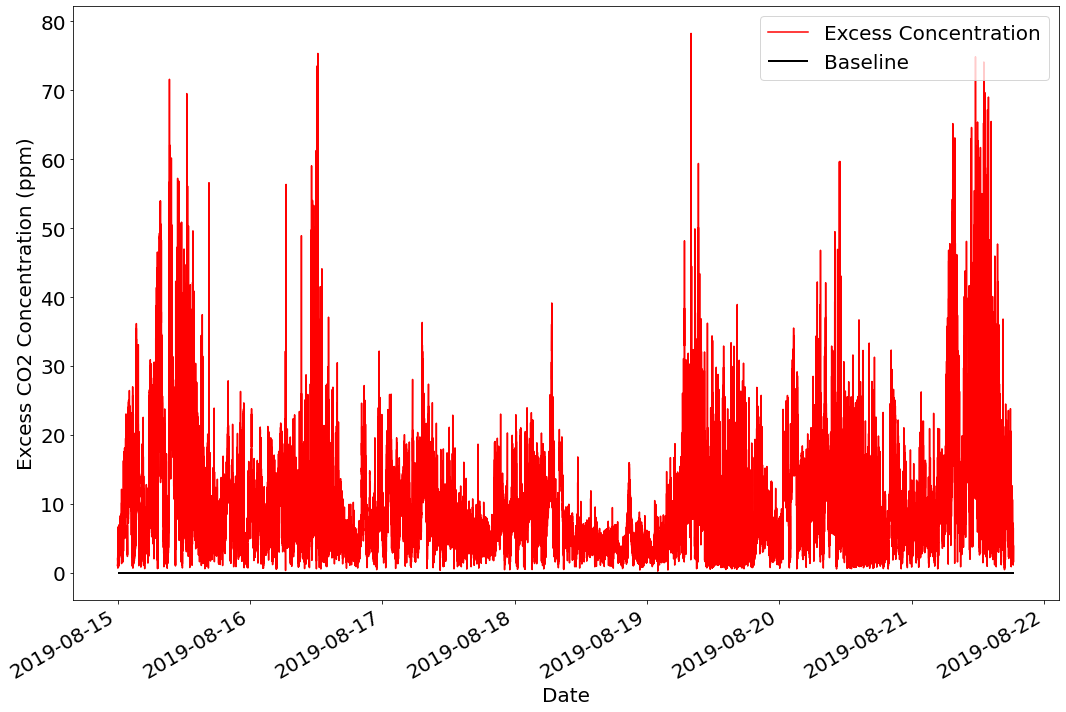

In [28]:
#Plot Excess Concentration over Baseline
labsize = 20

tower = 'Picarro'
position_number = 1
baseline_roll = 3600
ghg = 'Pic_CO2'
y_ax =f'excess_r{baseline_roll}_{ghg}'

plot_df = alldf.loc[alldf['Pic_Loc']==position_number]

start = 'all'#'2019-09-09'
end = '2019-09-11'
if start != 'all':
    plot_df = plot_df.loc[(plot_df.index>start)&(plot_df.index<end)]

fig,ax=plt.subplots(figsize=[15,10])

ax.plot(plot_df.index,plot_df[f'{y_ax}'],color='red',alpha=1,label = 'Excess Concentration')
ax.hlines(0,plot_df.index[0],plot_df.index[-1],color='black',linewidth=2,label='Baseline')

if ghg == 'Pic_CH4':
    ylab = 'Excess CH4 Concentration (ppm)'
elif ghg == 'Pic_CO2':
    ylab = 'Excess CO2 Concentration (ppm)'

ax.set_xlabel('Date',size=labsize)
ax.set_ylabel(ylab,size=labsize)
ax.tick_params(axis='both', which='major', labelsize=labsize)
ax.legend(fontsize = labsize,loc = 1)

plt.gcf().autofmt_xdate()
fig.tight_layout()
plt.show()

fig.savefig('../CO2_Data_Processed/Plots_Figs/CO2_excess.png')

# -------------
# Vent Mass Flow
# -------------

In [ ]:
alldf.columns

/uufs/chpc.utah.edu/common/home/u0890904/software/pkg/miniconda3/envs/CO2_Eddy/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


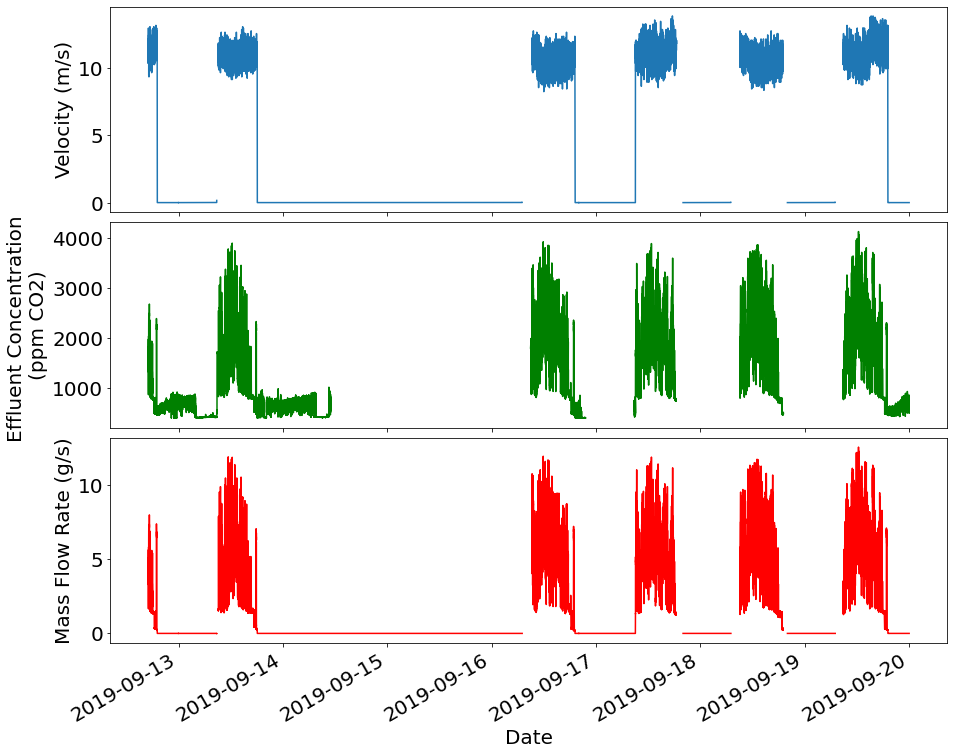

In [5]:
labsize = 20

position_number = 3

#To just view one position worth of data, input number to position_number
if position_number!='all':
    plot_df = alldf.loc[alldf['Pic_Loc']==position_number]
else:
    plot_df = alldf

start = 'all'#'2019-09-09'
end = '2019-09-11'
if start != 'all':
    plot_df = plot_df.loc[(plot_df.index>start)&(plot_df.index<end)]

fig = plt.figure(figsize=(15,13))

gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1]) 
gs.update(hspace=0.05)

#Top plot
y_ax0 = 'Vent_Exit_Vel'

ax0 = fig.add_subplot(gs[0])
ax0.plot(plot_df.index,plot_df[y_ax0],label='Effluent CO2 (Picarro Sampler)')
ax0.label_outer()
ax0.tick_params(axis='both', which='major', labelsize=labsize)
ax0.set_ylabel('Velocity (m/s)',size=labsize)

#Middle Plot
y_ax1 = 'Vent_Raw_Conc'
ax1 = fig.add_subplot(gs[1],sharex=ax0)
ax1.plot(plot_df.index,plot_df[y_ax1],'g')
ax1.tick_params(axis='both', which='major', labelsize=labsize)
ax1.set_ylabel('Effluent Concentration \n(ppm CO2)',size=labsize)

#Bottom Plot
y_ax1 = 'Vent_Mass_Flow'
ax2 = fig.add_subplot(gs[2],sharex=ax0)
ax2.plot(plot_df.index,plot_df[y_ax1],'r')
ax2.tick_params(axis='both', which='major', labelsize=labsize)
ax2.set_ylabel('Mass Flow Rate (g/s)',size=labsize)
ax2.set_xlabel('Date',size=labsize)

plt.gcf().autofmt_xdate()
fig.tight_layout()